<a href="https://colab.research.google.com/github/Conor-L/CSC3095-Machine-Learning/blob/master/Medical_Uses_of_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning with a Retinal Dataset provided by Kaggle User paultimothymooney

Import needed modules

In [ ]:
# Import needed modules
# ---------------------

from __future__ import absolute_import, division, print_function, unicode_literals

# Set TensorFlow version to 2.x
%tensorflow_version 2.x

#Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Softmax
from tensorflow.keras.losses import BinaryCrossentropy

# Helper Libraries
from keras_preprocessing.image import *
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

# Colab library needed for uploading files to this notebook
from google.colab import files

# Check the version of TensorFlow
print(tf.__version__)

# Install the Kaggle API
!pip install -q kaggle

2.2.0-rc4


Handle the API Token needed for retrieving dataset from Kaggle

In [ ]:
# Handle the API Token needed for retrieving dataset from Kaggle
# ---------------------

# Go to Kaggle > My Account > Create API Token > Upload here for access to dataset API
kaggle_api_token = files.upload()

# Create directory .kaggle
!mkdir /root/.kaggle

# Move the Kaggle API token to the newly created directory
!mv kaggle.json /root/.kaggle

# Ensure that kaggle.json is inside the .kaggle directory otherwise dataset download will not proceed
%cd /root/.kaggle
!ls -a

# Change permissons of the kaggle.json to secure its contents
!chmod 600 /root/.kaggle/kaggle.json

# Navigate back to /content/ where the dataset will be downloaded to
%cd /content/

Saving kaggle.json to kaggle.json
/root/.kaggle
.  ..  kaggle.json
/content


Handle the download of the dataset from Kaggle

In [ ]:
# Handle the download of the dataset from Kaggle
# ---------------------

# Download the dataset from Kaggle
!kaggle datasets download paultimothymooney/kermany2018

# Extract the dataset (quietly)
!unzip -qq kermany2018.zip

# Display the /content/ folder.
!ls

# Navigate to /content/'OCT2017 '/
%cd /content/'OCT2017 '/

# Check that train, val and test are all contained within the directory
!ls

100% 10.8G/10.8G [04:23<00:00, 61.6MB/s]
100% 10.8G/10.8G [04:23<00:00, 44.2MB/s]
 kermany2018.zip   oct2017  'OCT2017 '	 sample_data
/content/OCT2017 
test  train  val


Create Navigational Variables to the dataset directories


Number of CNV Images 37205
Number of DME Images 11348
Number of DRUSEN Images 8616
Number of NORMAL Images 26315

Total Directory Size:  83484
/content/OCT2017 /train


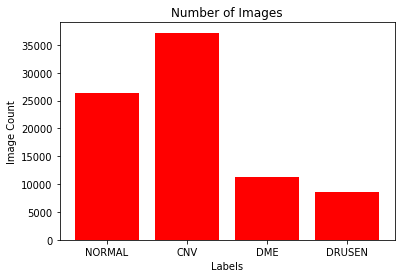

In [ ]:
# Create Navigational Variables to the dataset directories
# ---------------------

PATH = '/content/OCT2017 /train/'
total_directory = PATH

total_cnv_directory = os.path.join(total_directory, 'CNV')
total_dme_directory = os.path.join(total_directory, 'DME')
total_drusen_directory = os.path.join(total_directory, 'DRUSEN')
total_normal_directory = os.path.join(total_directory, 'NORMAL')

cnv_total_size = len(os.listdir(total_cnv_directory))
dme_total_size = len(os.listdir(total_dme_directory))
drusen_total_size = len(os.listdir(total_drusen_directory))
normal_total_size = len(os.listdir(total_normal_directory))

print('\nNumber of CNV Images', cnv_total_size)
print('Number of DME Images', dme_total_size)
print('Number of DRUSEN Images', drusen_total_size)
print('Number of NORMAL Images', normal_total_size)

total_directory_size = cnv_total_size + dme_total_size + drusen_total_size + normal_total_size
print('\nTotal Directory Size: ', total_directory_size)

%cd '/content/OCT2017 /train/'

# Draw a bar chart with the image count
x_axis = ["NORMAL", "CNV", "DME", "DRUSEN"]
x_ticks = np.arange(len(x_axis))
count = [normal_total_size, cnv_total_size, dme_total_size, drusen_total_size]
plt.bar(x_ticks, count, color="red")
plt.xlabel("Labels")
plt.ylabel("Image Count")
plt.title("Number of Images")
plt.xticks(x_ticks, x_axis)

plt.show()

Data Preprocessing

Found 66788 images belonging to 4 classes.
Found 16696 images belonging to 4 classes.


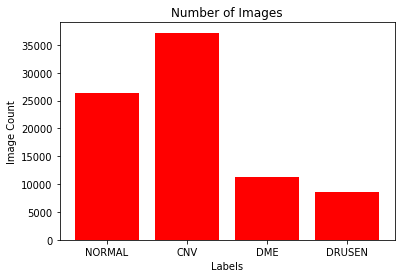

In [ ]:
# Data Preprocessing
# ---------------------

batch_size = 128
epochs = 15

image_dataset = ImageDataGenerator(rescale=1./255, validation_split=0.20)

test_dataset = ImageDataGenerator(rescale=1./255)

train_data = image_dataset.flow_from_directory(batch_size=batch_size, 
                                               directory=total_directory,
                                               target_size=(256, 256),
                                               class_mode='categorical',
                                               shuffle=True,
                                               color_mode='grayscale',
                                               subset='training')

val_data = image_dataset.flow_from_directory(batch_size=batch_size,
                                             directory=total_directory,
                                             target_size=(256, 256),
                                             class_mode='categorical',
                                             shuffle=True,
                                             color_mode='grayscale',
                                             subset='validation')


Model Creation

In [ ]:
# Model Creation
# ---------------------

# Model created and adapted with help from James Le: https://towardsdatascience.com/the-4-convolutional-neural-network-models-that-can-classify-your-fashion-images-9fe7f3e5399d to  ensure best accuracy output

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D((2,2)),
    keras.layers.Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    keras.layers.Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    keras.layers.Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    keras.layers.Dropout(0.25),

    Flatten(),

    Dense(256, activation='relu'),
    keras.layers.Dropout(0.25),
    Dense(4, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       7

Training the Model

In [ ]:
# Training the Model
# ---------------------

train_model = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // batch_size,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_data,
    validation_steps=val_data.samples // batch_size
)

Epoch 1/15
521/521 [==============================] - 387s 744ms/step - loss: 0.8735 - accuracy: 0.6752 - val_loss: 0.6085 - val_accuracy: 0.7864
Epoch 2/15
521/521 [==============================] - 360s 691ms/step - loss: 0.5549 - accuracy: 0.7975 - val_loss: 0.5354 - val_accuracy: 0.8176
Epoch 3/15
521/521 [==============================] - 308s 591ms/step - loss: 0.4549 - accuracy: 0.8350 - val_loss: 0.5065 - val_accuracy: 0.8261
Epoch 4/15
521/521 [==============================] - 304s 584ms/step - loss: 0.3893 - accuracy: 0.8600 - val_loss: 0.3911 - val_accuracy: 0.8651
Epoch 5/15
521/521 [==============================] - 300s 575ms/step - loss: 0.3272 - accuracy: 0.8830 - val_loss: 0.3570 - val_accuracy: 0.8749
Epoch 6/15
521/521 [==============================] - 300s 576ms/step - loss: 0.2708 - accuracy: 0.9061 - val_loss: 0.3327 - val_accuracy: 0.8906
Epoch 7/15
521/521 [==============================] - 299s 573ms/step - loss: 0.2178 - accuracy: 0.9253 - val_loss: 0.3045 -

Pre-Process Test Data

In [ ]:
# Pre-Process Test Data
# ---------------------

itr = test_data = test_dataset.flow_from_directory(batch_size=968,
                                             directory='/content/OCT2017 /test',
                                             target_size=(256, 256),
                                             class_mode='categorical',
                                             color_mode='grayscale',
                                             shuffle=True)

X_test, y_test = itr.next()

Found 968 images belonging to 4 classes.


Create a Matrix for the results

In [ ]:
# Import needed modules
# ---------------------

w, h = 4, 4;
Matrix = [[0 for x in range(w)] for y in range(h)] 

trueResult = np.where(y_test == 1)
correctPos = list(zip(trueResult[0], trueResult[1]))

testPredictions = model.predict(X_test[:len(X_test)])

i = 0
for element in X_test:
  currentPrediction = np.amax(testPredictions[i])
  labelArrPos = np.where(testPredictions[i] == currentPrediction)
  Matrix[correctPos[i][1]][labelArrPos[0][0]] += 1
  i = i + 1

print(Matrix[0], "\n", Matrix[1], "\n", Matrix[2], "\n", Matrix[3])

[241, 1, 0, 0] 
 [10, 225, 0, 7] 
 [7, 0, 234, 1] 
 [0, 0, 0, 242]


Draw the Matrix to the screen

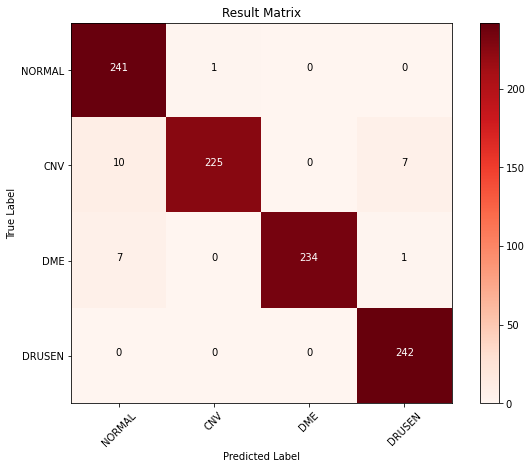

In [ ]:
# Draw the Matrix to the screen
# ---------------------

# With help from https://snakify.org/en/lessons/two_dimensional_lists_arrays/ Lesson 9 Two-Dimensional Arrays - Looping through two Dimensional arrays
#   to print the values onto the Result Matrix

# Issues resolved with help from https://stackoverflow.com/questions/21712047/matplotlib-imshow-matshow-display-values-on-plot How to print text onto the result matrix

plt.figure(figsize=(10, 7))
plt.imshow(Matrix, interpolation='nearest', cmap=plt.cm.Reds)
plt.title("Result Matrix")
plt.colorbar()

dataset_classes = ["NORMAL", "CNV", "DME", "DRUSEN"]
axis_labels = np.arange(len(dataset_classes))

plt.xticks(axis_labels, dataset_classes, rotation=45)
plt.yticks(axis_labels, dataset_classes)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

threshold = np.amax(Matrix) / 2

for i in range(len(Matrix)):
  for j in range(len(Matrix[i])):
    plt.text(j, i, Matrix[i][j], horizontalalignment="center", color="white" if Matrix[i][j] > threshold else "black")

  

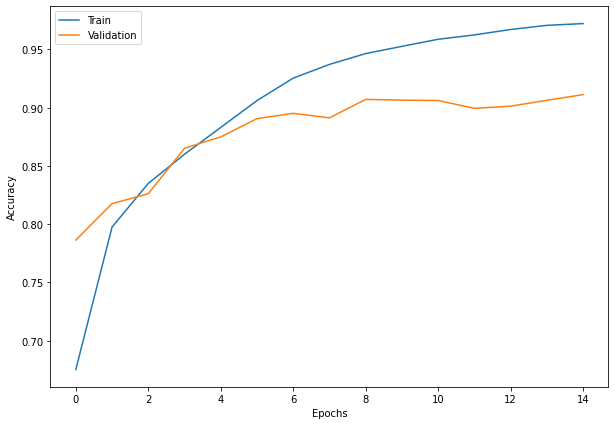

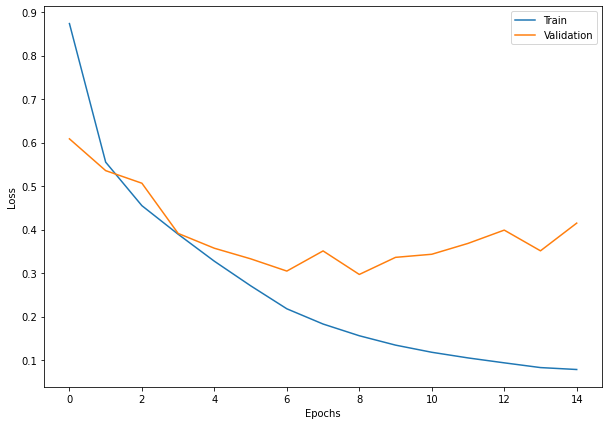

In [ ]:
#Plot Accuracy against Validation Accuracy
plt.figure(figsize=(10, 7))
plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend(['Train', 'Validation'], loc='upper left')

#Plot Loss against Validation Loss
plt.figure(figsize=(10, 7))
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(['Train', 'Validation'], loc='upper right')